In [1]:
import os
from copy import deepcopy

import random

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [2]:
df_X = pd.read_csv("./data/x_train.csv", header=None)
df_y = pd.read_csv("./data/y_train.csv", header=None)

In [3]:
np_X = df_X.to_numpy()
np_y = df_y.to_numpy()[:, 0]

Решим задачу классификации на две группы:
* точки с y, близким к медианному значению
* оставшиеся точки

Для этого применим нейронную сеть

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5]),
 [Text(0, 0.5, '0'),
  Text(0, 1.5, '1'),
  Text(0, 2.5, '2'),
  Text(0, 3.5, '3'),
  Text(0, 4.5, '4'),
  Text(0, 5.5, '5'),
  Text(0, 6.5, '6'),
  Text(0, 7.5, '7'),
  Text(0, 8.5, '8'),
  Text(0, 9.5, '9'),
  Text(0, 10.5, '10'),
  Text(0, 11.5, '11'),
  Text(0, 12.5, '12'),
  Text(0, 13.5, '13'),
  Text(0, 14.5, '14'),
  Text(0, 15.5, '15')])

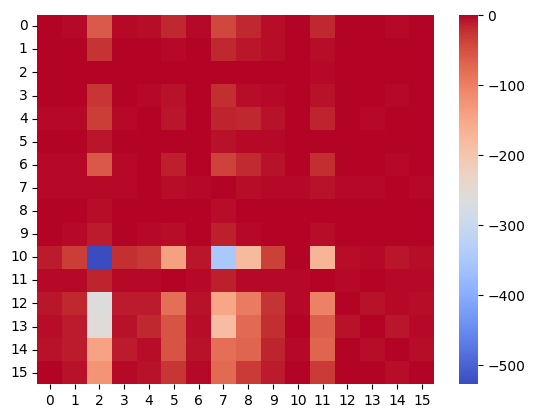

In [20]:
# Поиск корелляций среди параметров X
np_X_R2 = [[r2_score(np_X[:, i], np_X[:, j]) for j in range(np_X.shape[-1])] for i in range(np_X.shape[-1])]
np_X_R2 = np.array(np_X_R2)
sns.heatmap(np_X_R2, cmap="coolwarm")
plt.yticks(rotation=0)

Text(0, 0.5, 'Count')

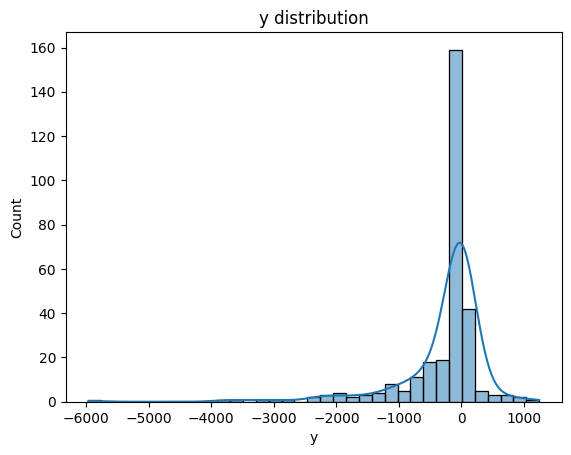

In [6]:
# Распределение точек по y
sns.histplot(np_y, kde=True, legend=False)
plt.title('y distribution')
plt.xlabel('y')
plt.ylabel('Count')

In [ ]:
# Найдем медианное значение
median_y = np.median(np_y)
median_y

np.float64(-17.556392250000002)

In [8]:
# rate - доля точек, которые мы отнесем к первой группе 
# В данном случае rate=0.5, т.е. точек в двух группах поровну
rate = 0.5
# Производим разбиение точек по степени близости y к median_y
# Для нахождения необходимого значения используем бинарный поиск по ответу
L_d, R_d = 0, np.max(np_y) - np.min(np_y)
for i in range(200):
    M_d = (L_d + R_d) / 2
    np_X_0, np_X_1 = [], []
    np_y_0, np_y_1 = [], []
    for i in range(np_X.shape[0]):
        if median_y - M_d <= np_y[i] <= median_y + M_d:
            np_X_0.append(np_X[i])
            np_y_0.append(np_y[i])
        else:
            np_X_1.append(np_X[i])
            np_y_1.append(np_y[i])
    if len(np_y_0) / len(np_y) < rate:
        L_d = M_d
    else:    
        R_d = M_d
d_y = M_d

np_X_0, np_X_1 = [], []
np_y_0, np_y_1 = [], []
# Значения массива np_y_bin отражают, к какой из групп относится точка
# 0 - первая группа
# 1 - вторая группа
# Этот массив необходим для обучения и проверки нейросети
np_y_bin = []
for i in range(np_X.shape[0]):
    if median_y - M_d <= np_y[i] <= median_y + M_d:
        np_X_0.append(np_X[i])
        np_y_0.append(np_y[i])
        np_y_bin.append(0)
    else:
        np_X_1.append(np_X[i])
        np_y_1.append(np_y[i])
        np_y_bin.append(1)
np_X_0 = np.array(np_X_0)
np_y_0 = np.array(np_y_0)
np_X_1 = np.array(np_X_1)
np_y_1 = np.array(np_y_1)
np_y_bin = np.array(np_y_bin)

In [ ]:
# Выводим данные о классификации
print(f"median_y: {round(median_y)}, d_y: {round(d_y)}, rate = {rate}")
print(f"Len_0 = {len(np_y_0)}, Len_1 = {len(np_y_1)}")

median_y: -18, d_y: 72, rate = 0.5
Len_0 = 150, Len_1 = 150


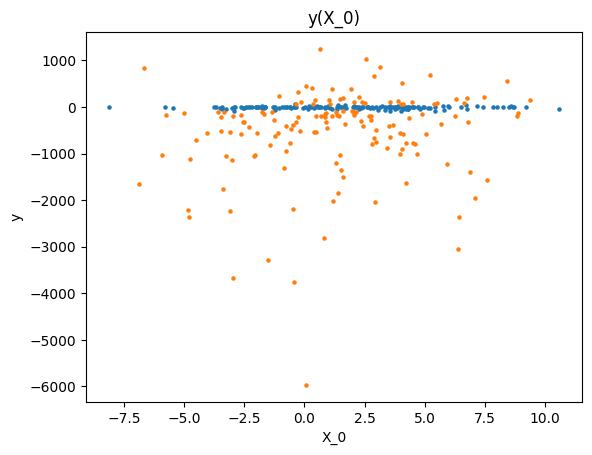

In [10]:
# Построим y(X_0) с учётом классификации
i_X = 0
plt.title(f"y(X_{i_X})")
plt.xlabel(f"X_{i_X}")
plt.ylabel("y")
plt.scatter(np_X_0[:, i_X], np_y_0, s=5)
plt.scatter(np_X_1[:, i_X], np_y_1, s=5)

<Axes: ylabel='Count'>

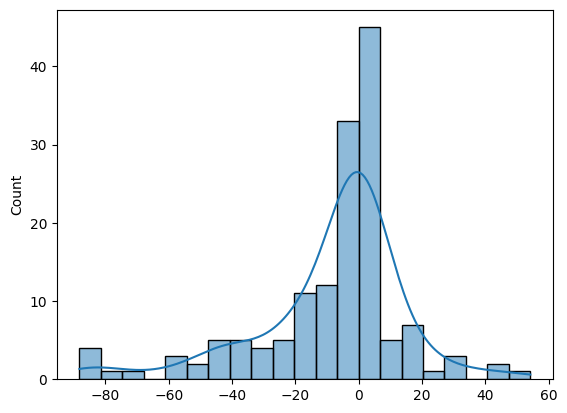

In [11]:
# Распределение y в группе 0
sns.histplot(np_y_0, kde=True, legend=False)

<Axes: ylabel='Count'>

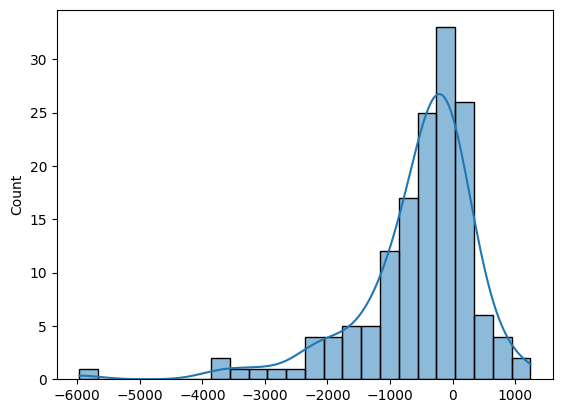

In [12]:
# Распределение y в группе 1
sns.histplot(np_y_1, kde=True, legend=False)

Классификация на 0/1 по 16 признакам

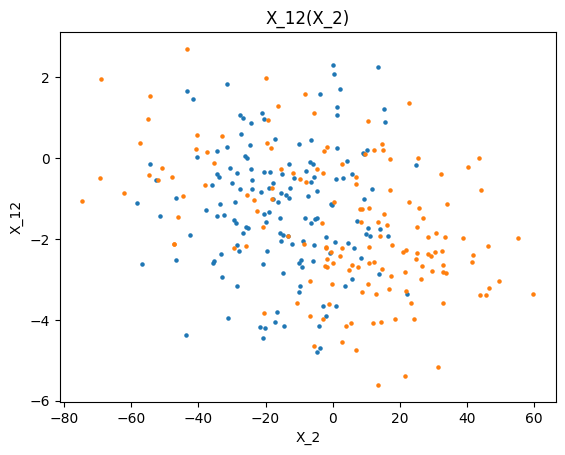

In [13]:
# Поиск зависимостей в данных
# В данном случае строим X_12(X_2)
i_X, j_X = 2, 12
plt.title(f"X_{j_X}(X_{i_X})")
plt.xlabel(f"X_{i_X}")
plt.ylabel(f"X_{j_X}")
plt.scatter(np_X_0[:, i_X], np_X_0[:, j_X], s=5)
plt.scatter(np_X_1[:, i_X], np_X_1[:, j_X], s=5)

In [14]:
X_train_clf, X_val_clf, y_train_clf, y_val_clf = train_test_split(np_X, np_y_bin, test_size=0.4, random_state=42)

Решающее дерево

In [15]:
decision_clf = DecisionTreeClassifier(random_state=42, max_depth=5, criterion='entropy')
decision_clf.fit(X_train_clf, y_train_clf)

,criterion,'entropy'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [16]:
accuracy_score(decision_clf.predict(X_val_clf), y_val_clf)

0.8

Нейронная сеть

In [17]:
class ClassificationDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return torch.tensor(self.X[i]).float(), torch.tensor(self.y[i]).long()

In [ ]:
class NNClassification:
    def __init__(self, n_hidden=128, n_hidden_layers=2, lr=1e-3, n_epochs=200, batch_size=32, sigmoid_rate=0):
        self.n_hidden = n_hidden
        self.n_hidden_layers = n_hidden_layers
        self.lr = lr
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        # sigmoid_rate - доля sigmoid среди функций активации
        self.sigmoid_rate = sigmoid_rate
        self.model = None
        self.train_loss = None
        self.val_loss = None
    
    def fit(self, X_train, y_train, X_val, y_val):
        n_val_X = X_train.shape[-1]
        n_val_y = len(np.unique(y_train))

        lawyers = [nn.Linear(n_val_X, self.n_hidden), nn.ReLU()]
        for i in range(self.n_hidden_layers):
            lawyers.append(nn.Linear(self.n_hidden, self.n_hidden))
            if random.random() < self.sigmoid_rate:
                lawyers.append(nn.Sigmoid())
            else:
                lawyers.append(nn.ReLU())
        lawyers.append(nn.Linear(self.n_hidden, n_val_y))
        self.model = nn.Sequential(*lawyers)
        
        optim = Adam(self.model.parameters(), lr=self.lr)
        dataset = ClassificationDataset(X_train, y_train)
        dataloader = DataLoader(dataset, shuffle=True, batch_size=self.batch_size)
        self.train_loss = []

        val_dataset = ClassificationDataset(X_val, y_val)
        val_dataloader = DataLoader(val_dataset, batch_size=self.batch_size)
        self.val_loss = []

        best_model = None
        best_num_epoch = None
        best_val_loss = None
        
        for epoch in range(1, self.n_epochs + 1):
            losses = []
            for x_batch, y_batch in dataloader:
                y_pred = self.model(x_batch)
                loss = F.cross_entropy(y_pred, y_batch)
                optim.zero_grad()
                loss.backward()
                optim.step()
                losses.append(loss.detach().item())
            self.train_loss.append(np.mean(losses))

            with torch.no_grad():
                losses = []
                for x_batch, y_batch in val_dataloader:
                    y_pred = self.model(x_batch)
                    loss = F.cross_entropy(y_pred, y_batch)
                    losses.append(loss.detach().item())
                self.val_loss.append(np.mean(losses))
            
            if best_val_loss == None or best_val_loss > self.val_loss[-1]:
                best_val_loss = self.val_loss[-1]
                best_num_epoch = epoch
                best_model = deepcopy(self.model)
            if epoch % 20 == 0:
                # Вывод сведений о процессе обучения
                print(f"Epoch {epoch}, loss {self.val_loss[-1]}")
        self.model = deepcopy(best_model)
        # Лучшая модель
        print(f"Best loss was at {best_num_epoch} epoch: {best_val_loss}")

    def predict(self, X):
        with torch.no_grad():
            X = torch.tensor(X).float()
            y = self.model(X).numpy()
            return np.argmax(y, axis=-1)

In [19]:
# Гиперпараметры
n_hidden_clf = 6
n_hidden_layers_clf = 3
lr_clf = 1e-3
n_epochs_clf = 200
batch_size_clf = 1
sigmoid_rate_clf = 0

In [796]:
model_clf = NNClassification(n_hidden=n_hidden_clf, n_hidden_layers=n_hidden_layers_clf, lr=lr_clf, n_epochs=n_epochs_clf, batch_size=batch_size_clf, sigmoid_rate=sigmoid_rate_clf)
model_clf.fit(X_train_clf, y_train_clf, X_val_clf, y_val_clf)

Epoch 20, loss 0.517537907914569
Epoch 40, loss 0.5234521176045139
Epoch 60, loss 0.5553412154132578
Epoch 80, loss 0.5766659148721374
Epoch 100, loss 0.6489316881757986
Epoch 120, loss 0.6262354458890816
Epoch 140, loss 0.7196530648073046
Epoch 160, loss 0.671063477320907
Epoch 180, loss 0.6425784629045059
Epoch 200, loss 0.751684062985502
Best loss was at 25 epoch: 0.48953859889879825


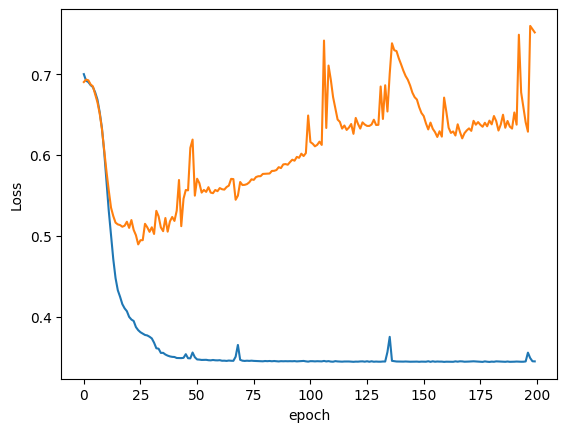

In [ ]:
# График функции потерь на тренировочной и валидационной выборках

# Начинаем строить график, начиная с конкретной эпохи
cut_start_clf = 0
# Начинаем строить график, заканчивая конкретной эпохой
cut_end_clf = 0
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(np.arange(int(len(model_clf.train_loss) * cut_start_clf), len(model_clf.train_loss) - int(len(model_clf.train_loss) * cut_end_clf)), 
         model_clf.train_loss[int(len(model_clf.train_loss) * cut_start_clf):len(model_clf.train_loss) - int(len(model_clf.train_loss) * cut_end_clf)])
plt.plot(np.arange(int(len(model_clf.val_loss) * cut_start_clf), len(model_clf.val_loss) - int(len(model_clf.val_loss) * cut_end_clf)), 
         model_clf.val_loss[int(len(model_clf.val_loss) * cut_start_clf):len(model_clf.val_loss) - int(len(model_clf.val_loss) * cut_end_clf)])

In [798]:
print(f"Accuracy: {accuracy_score(y_val_clf, model_clf.predict(X_val_clf))}")

Accuracy: 0.8


In [ ]:
cur = 0
for file_name in os.listdir("./classifications"):
    if file_name.startswith("classification") and file_name.endswith('.pth'):
        cur += 1
# Сохраняем модель
torch.save(model_clf, f"./classifications/classification_{cur}.pth")
# Сохраняем информацию о гиперпараметрах модели
with open("./classifications/info.txt", 'a') as f:
    print(f"{cur}. n_hidden = {n_hidden_clf}, n_hidden_layers = {n_hidden_layers_clf}, lr = {lr_clf}, n_epochs = {n_epochs_clf}, batch_size = {batch_size_clf}, sigmoid_rate = {sigmoid_rate_clf}, accuracy: {round(accuracy_score(y_val_clf, model_clf.predict(X_val_clf)), 3)}", file=f)